In [1]:
import torch
from tqdm import tqdm
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import SimpleITK as sitk
from lazy_imports import itkwidgets
from lazy_imports import itkview
from lazy_imports import interactive
from lazy_imports import ipywidgets
from lazy_imports import pv

In [2]:
from mtch.RegistrationFunc3D import *
from mtch.SplitEbinMetric3D import *
from mtch.GeoPlot import *

In [3]:
# from Packages.disp.vis import show_2d, show_2d_tensors
from disp.vis import vis_tensors, vis_path, disp_scalar_to_file
from disp.vis import disp_vector_to_file, disp_tensor_to_file
from disp.vis import disp_gradG_to_file, disp_gradA_to_file
from disp.vis import view_3d_tensors, tensors_to_mesh

In [4]:
import algo.metricModSolver2d as mms
import algo.geodesic as geo
import algo.euler as euler
import algo.dijkstra as dijkstra

## I/O convention
Due to the certain reason of Kris' simulated data generation, please follow the i/o convention below which is symmetric, to make sure the files are read and written correctly. Following example is for 2D situation, 3D case is analogous.
### Read
Shape of input_tensor.nhdr is [w, h, 3], and Shape of input_mask.nhdr is [w, h]
```
input_tensor = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(path)),(2,1,0))
input_mask = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(path)),(1,0))
```
input_tensor.shape is [3, h, w], and input_mask.shape is [h, w]
### Write
output_tensor.shape is [3, h, w], and output_mask.shape is [h, w]
```
output_tensor = sitk.WriteImage(sitk.GetImageFromArray(np.transpose(output_tensor,(2,1,0)), path)
output_mask = sitk.WriteImage(sitk.GetImageFromArray(np.transpose(output_tensor,(2,1,0)), path)
```
Shape of output_tensor.nhdr is [w, h, 3], and Shape of output_mask.nhdr is [w, h]

### Note
`sitk.WriteImage(sitk.GetImageFromArray())` and `sitk.GetArrayFromImage(sitk.ReadImage(path))` is a pair of inverse operation, and you can see there is no inconsistence with regards to the dimension issue.
```
output_tensor = np.zeros((12,34,56,78))
sitk.WriteImage(sitk.GetImageFromArray(output_tensor), path)
input_tensor = sitk.GetArrayFromImage(sitk.ReadImage(path))
print(input_tensor)
'(12,34,56,78)'
```

## Import data

In [5]:
index0, index1 = 4, 6
input_dir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/working_3d_python'
output_dir = 'Cubic46Geo'
g0_lin = torch.from_numpy(sitk.GetArrayFromImage(sitk.ReadImage(f'{input_dir}/cubic{index0}_scaled_tensors.nhdr'))).double().permute(3,2,1,0)
g1_lin = torch.from_numpy(sitk.GetArrayFromImage(sitk.ReadImage(f'{input_dir}/cubic{index1}_scaled_tensors.nhdr'))).double().permute(3,2,1,0)

height, width, depth = 100,100,41
g0_met, g1_met = torch.zeros(height, width, depth, 3, 3, dtype=torch.double), torch.zeros(height, width, depth, 3, 3, dtype=torch.double)
g0_met[:,:,:,0,0] = g0_lin[0]
g0_met[:,:,:,0,1] = g0_lin[1]
g0_met[:,:,:,0,2] = g0_lin[2]
g0_met[:,:,:,1,0] = g0_lin[1]
g0_met[:,:,:,1,1] = g0_lin[3]
g0_met[:,:,:,1,2] = g0_lin[4]
g0_met[:,:,:,2,0] = g0_lin[2]
g0_met[:,:,:,2,1] = g0_lin[4]
g0_met[:,:,:,2,2] = g0_lin[5]

g1_met[:,:,:,0,0] = g1_lin[0]
g1_met[:,:,:,0,1] = g1_lin[1]
g1_met[:,:,:,0,2] = g1_lin[2]
g1_met[:,:,:,1,0] = g1_lin[1]
g1_met[:,:,:,1,1] = g1_lin[3]
g1_met[:,:,:,1,2] = g1_lin[4]
g1_met[:,:,:,2,0] = g1_lin[2]
g1_met[:,:,:,2,1] = g1_lin[4]
g1_met[:,:,:,2,2] = g1_lin[5]

## Calculate Geodesic

In [6]:
Tpts = 7
geo_met_list = get_geo(g0_met, g1_met, 1./3., Tpts)

This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370141920/work/torch/csrc/utils/python_arg_parser.cpp:882.)


## Save Result

In [7]:
geo_lin_list = []
geo_mask_list = []

for i in range(Tpts):
    geo_lin = torch.zeros((6,height,width,depth))
    geo_lin[0]=geo_met_list[i][:,:,:,0,0]
    geo_lin[1]=geo_met_list[i][:,:,:,0,1]
    geo_lin[2]=geo_met_list[i][:,:,:,0,2]
    geo_lin[3]=geo_met_list[i][:,:,:,1,1]
    geo_lin[4]=geo_met_list[i][:,:,:,1,2]
    geo_lin[5]=geo_met_list[i][:,:,:,2,2]
    geo_mask = torch.where(torch.det(geo_met_list[i])>1,1,0)
    geo_lin_list.append(geo_lin)
    geo_mask_list.append(geo_mask)
    sitk.WriteImage(sitk.GetImageFromArray(geo_lin.permute(3,2,1,0).numpy()), f'{output_dir}/cubic_46_geodesic_{i}_tens.nhdr')
    sitk.WriteImage(sitk.GetImageFromArray(geo_mask.permute(2,1,0).numpy()), f'{output_dir}/cubic_46_geodesic_{i}_mask.nhdr')

In [8]:
# vwr = itkview(torch.where(torch.det(geo_met_list[i])>1,1,0))
# vwr
start_coords = [[13, 14, 21]]
init_velocities = [None]
geo_delta_t = -0.08
geo_iters = 1300 

In [11]:
tensor_lin = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{output_dir}/cubic_46_geodesic_{0}_tens.nhdr')),(3,2,1,0))
mask = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{output_dir}/cubic_46_geodesic_{0}_mask.nhdr')),(2,1,0))
geox, geoy, geoz = geo.geodesicpath_3d(tensor_lin, mask,\
                                        start_coords[0], init_velocities[0], \
                                        geo_delta_t, iter_num=geo_iters, both_directions=False)
vwr = view_3d_tensors(np.transpose(tensor_lin,(1,2,3,0)),
                      mask,
                      mask,
                      paths=[],stride=6,scale=6)
vwr

Finding geodesic path from [13, 14, 21] with initial velocity [0.26580047 0.96402806 0.        ]
masking pixel 8 14 16 for boundary type shiftzbottomleft
masking pixel 8 14 17 for boundary type shiftzbottomleft
masking pixel 8 14 24 for boundary type shiftzbottomleft
masking pixel 8 14 25 for boundary type shiftzbottomleft
masking pixel 8 15 16 for boundary type rearshiftyleft
masking pixel 8 16 16 for boundary type rearshiftyleft
masking pixel 10 14 14 for boundary type rearshiftbottomleft
masking pixel 10 15 14 for boundary type rearshiftyleft
masking pixel 10 27 20 for boundary type shiftztopleft
masking pixel 10 27 21 for boundary type shiftztopleft
masking pixel 15 37 20 for boundary type shiftztopleft
masking pixel 15 37 21 for boundary type shiftztopleft
masking pixel 17 40 20 for boundary type shiftztopleft
masking pixel 17 40 21 for boundary type shiftztopleft
masking pixel 20 44 20 for boundary type shiftztopleft
masking pixel 20 44 21 for boundary type shiftztopleft
masking 

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [12]:
tensor_lin = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{output_dir}/cubic_46_geodesic_{1}_tens.nhdr')),(3,2,1,0))
mask = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{output_dir}/cubic_46_geodesic_{1}_mask.nhdr')),(2,1,0))
geox, geoy, geoz = geo.geodesicpath_3d(tensor_lin, mask,\
                                        start_coords[0], init_velocities[0], \
                                        geo_delta_t, iter_num=geo_iters, both_directions=False)
vwr = view_3d_tensors(np.transpose(tensor_lin,(1,2,3,0)),
                      mask,
                      mask,
                      paths=[],stride=6,scale=6)
vwr

Finding geodesic path from [13, 14, 21] with initial velocity [0.26896079 0.96315113 0.        ]
masking pixel 8 14 16 for boundary type shiftzbottomleft
masking pixel 8 14 17 for boundary type shiftzbottomleft
masking pixel 8 14 24 for boundary type shiftzbottomleft
masking pixel 8 14 25 for boundary type shiftzbottomleft
masking pixel 8 15 16 for boundary type rearshiftyleft
masking pixel 8 16 16 for boundary type rearshiftyleft
masking pixel 10 14 14 for boundary type rearshiftbottomleft
masking pixel 10 15 14 for boundary type rearshiftyleft
masking pixel 10 27 20 for boundary type shiftztopleft
masking pixel 10 27 21 for boundary type shiftztopleft
masking pixel 15 37 20 for boundary type shiftztopleft
masking pixel 15 37 21 for boundary type shiftztopleft
masking pixel 17 40 20 for boundary type shiftztopleft
masking pixel 17 40 21 for boundary type shiftztopleft
masking pixel 19 11 19 for boundary type rearbottomshiftx
masking pixel 19 11 20 for boundary type rearbottomshiftx
ma

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [13]:
tensor_lin = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{output_dir}/cubic_46_geodesic_{2}_tens.nhdr')),(3,2,1,0))
mask = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{output_dir}/cubic_46_geodesic_{2}_mask.nhdr')),(2,1,0))
geox, geoy, geoz = geo.geodesicpath_3d(tensor_lin, mask,\
                                        start_coords[0], init_velocities[0], \
                                        geo_delta_t, iter_num=geo_iters, both_directions=False)
vwr = view_3d_tensors(np.transpose(tensor_lin,(1,2,3,0)),
                      mask,
                      mask,
                      paths=[],stride=6,scale=6)
vwr

Finding geodesic path from [13, 14, 21] with initial velocity [0.27209659 0.96226994 0.        ]
masking pixel 8 14 16 for boundary type shiftzbottomleft
masking pixel 8 14 17 for boundary type shiftzbottomleft
masking pixel 8 14 24 for boundary type shiftzbottomleft
masking pixel 8 14 25 for boundary type shiftzbottomleft
masking pixel 8 15 16 for boundary type rearshiftyleft
masking pixel 8 16 16 for boundary type rearshiftyleft
masking pixel 10 14 14 for boundary type rearshiftbottomleft
masking pixel 10 15 14 for boundary type rearshiftyleft
masking pixel 10 27 20 for boundary type shiftztopleft
masking pixel 10 27 21 for boundary type shiftztopleft
masking pixel 15 37 20 for boundary type shiftztopleft
masking pixel 15 37 21 for boundary type shiftztopleft
masking pixel 17 40 20 for boundary type shiftztopleft
masking pixel 17 40 21 for boundary type shiftztopleft
masking pixel 19 11 19 for boundary type rearbottomshiftx
masking pixel 19 11 20 for boundary type rearbottomshiftx
ma

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [14]:
tensor_lin = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{output_dir}/cubic_46_geodesic_{3}_tens.nhdr')),(3,2,1,0))
mask = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{output_dir}/cubic_46_geodesic_{3}_mask.nhdr')),(2,1,0))
geox, geoy, geoz = geo.geodesicpath_3d(tensor_lin, mask,\
                                        start_coords[0], init_velocities[0], \
                                        geo_delta_t, iter_num=geo_iters, both_directions=False)
vwr = view_3d_tensors(np.transpose(tensor_lin,(1,2,3,0)),
                      mask,
                      mask,
                      paths=[],stride=6,scale=6)
vwr

Finding geodesic path from [13, 14, 21] with initial velocity [0.27520736 0.96138489 0.        ]
masking pixel 8 14 16 for boundary type shiftzbottomleft
masking pixel 8 14 17 for boundary type shiftzbottomleft
masking pixel 8 14 24 for boundary type shiftzbottomleft
masking pixel 8 14 25 for boundary type shiftzbottomleft
masking pixel 8 15 16 for boundary type rearshiftyleft
masking pixel 8 16 16 for boundary type rearshiftyleft
masking pixel 10 14 14 for boundary type rearshiftbottomleft
masking pixel 10 15 14 for boundary type rearshiftyleft
masking pixel 10 27 20 for boundary type shiftztopleft
masking pixel 10 27 21 for boundary type shiftztopleft
masking pixel 15 37 20 for boundary type shiftztopleft
masking pixel 15 37 21 for boundary type shiftztopleft
masking pixel 17 40 20 for boundary type shiftztopleft
masking pixel 17 40 21 for boundary type shiftztopleft
masking pixel 19 11 19 for boundary type rearbottomshiftx
masking pixel 19 11 20 for boundary type rearbottomshiftx
ma

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [15]:
tensor_lin = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{output_dir}/cubic_46_geodesic_{4}_tens.nhdr')),(3,2,1,0))
mask = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{output_dir}/cubic_46_geodesic_{4}_mask.nhdr')),(2,1,0))
geox, geoy, geoz = geo.geodesicpath_3d(tensor_lin, mask,\
                                        start_coords[0], init_velocities[0], \
                                        geo_delta_t, iter_num=geo_iters, both_directions=False)
vwr = view_3d_tensors(np.transpose(tensor_lin,(1,2,3,0)),
                      mask,
                      mask,
                      paths=[],stride=6,scale=6)
vwr

Finding geodesic path from [13, 14, 21] with initial velocity [0.27829286 0.96049627 0.        ]
masking pixel 8 14 16 for boundary type shiftzbottomleft
masking pixel 8 14 17 for boundary type shiftzbottomleft
masking pixel 8 14 24 for boundary type shiftzbottomleft
masking pixel 8 14 25 for boundary type shiftzbottomleft
masking pixel 8 15 16 for boundary type rearshiftyleft
masking pixel 8 16 16 for boundary type rearshiftyleft
masking pixel 10 14 14 for boundary type rearshiftbottomleft
masking pixel 10 15 14 for boundary type rearshiftyleft
masking pixel 10 27 20 for boundary type shiftztopleft
masking pixel 10 27 21 for boundary type shiftztopleft
masking pixel 15 37 20 for boundary type shiftztopleft
masking pixel 15 37 21 for boundary type shiftztopleft
masking pixel 17 40 20 for boundary type shiftztopleft
masking pixel 17 40 21 for boundary type shiftztopleft
masking pixel 19 11 19 for boundary type rearbottomshiftx
masking pixel 19 11 20 for boundary type rearbottomshiftx
ma

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [16]:
tensor_lin = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{output_dir}/cubic_46_geodesic_{5}_tens.nhdr')),(3,2,1,0))
mask = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{output_dir}/cubic_46_geodesic_{5}_mask.nhdr')),(2,1,0))
geox, geoy, geoz = geo.geodesicpath_3d(tensor_lin, mask,\
                                        start_coords[0], init_velocities[0], \
                                        geo_delta_t, iter_num=geo_iters, both_directions=False)
vwr = view_3d_tensors(np.transpose(tensor_lin,(1,2,3,0)),
                      mask,
                      mask,
                      paths=[],stride=6,scale=6)
vwr

Finding geodesic path from [13, 14, 21] with initial velocity [0.28135269 0.95960443 0.        ]
masking pixel 8 14 16 for boundary type shiftzbottomleft
masking pixel 8 14 17 for boundary type shiftzbottomleft
masking pixel 8 14 24 for boundary type shiftzbottomleft
masking pixel 8 14 25 for boundary type shiftzbottomleft
masking pixel 8 15 16 for boundary type rearshiftyleft
masking pixel 8 16 16 for boundary type rearshiftyleft
masking pixel 10 14 14 for boundary type rearshiftbottomleft
masking pixel 10 15 14 for boundary type rearshiftyleft
masking pixel 10 27 20 for boundary type shiftztopleft
masking pixel 10 27 21 for boundary type shiftztopleft
masking pixel 15 37 20 for boundary type shiftztopleft
masking pixel 15 37 21 for boundary type shiftztopleft
masking pixel 17 40 20 for boundary type shiftztopleft
masking pixel 17 40 21 for boundary type shiftztopleft
masking pixel 19 11 19 for boundary type rearbottomshiftx
masking pixel 19 11 20 for boundary type rearbottomshiftx
ma

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [17]:
tensor_lin = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{output_dir}/cubic_46_geodesic_{6}_tens.nhdr')),(3,2,1,0))
mask = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(f'{output_dir}/cubic_46_geodesic_{6}_mask.nhdr')),(2,1,0))
geox, geoy, geoz = geo.geodesicpath_3d(tensor_lin, mask,\
                                        start_coords[0], init_velocities[0], \
                                        geo_delta_t, iter_num=geo_iters, both_directions=False)
vwr = view_3d_tensors(np.transpose(tensor_lin,(1,2,3,0)),
                      mask,
                      mask,
                      paths=[],stride=6,scale=6)
vwr

Finding geodesic path from [13, 14, 21] with initial velocity [0.28438653 0.95870971 0.        ]
masking pixel 7 18 20 for boundary type shiftztopleft
masking pixel 7 18 21 for boundary type shiftztopleft
masking pixel 8 15 16 for boundary type rearshiftyleft
masking pixel 8 15 25 for boundary type frontshiftyleft
masking pixel 8 16 16 for boundary type rearshiftyleft
masking pixel 8 16 25 for boundary type frontshiftyleft
masking pixel 8 21 20 for boundary type shiftztopleft
masking pixel 8 21 21 for boundary type shiftztopleft
masking pixel 10 14 14 for boundary type rearshiftbottomleft
masking pixel 10 15 14 for boundary type rearshiftyleft
masking pixel 12 13 18 for boundary type shiftzbottomleft
masking pixel 12 13 19 for boundary type shiftzbottomleft
masking pixel 12 13 22 for boundary type shiftzbottomleft
masking pixel 12 13 23 for boundary type shiftzbottomleft
masking pixel 12 13 26 for boundary type shiftzbottomleft
masking pixel 12 13 27 for boundary type shiftfrontbottoml

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

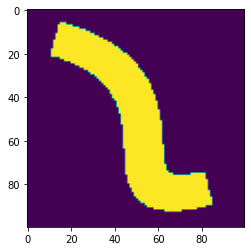

In [5]:
mask00 = torch.from_numpy(sitk.GetArrayFromImage(sitk.ReadImage(f'Data/Cubic/cubic{index0}_filt_mask.nhdr'))).double().permute(1,0)
mask11 = torch.from_numpy(sitk.GetArrayFromImage(sitk.ReadImage(f'Data/Cubic/cubic{index1}_filt_mask.nhdr'))).double().permute(1,0)
mask = mask00+mask11
mask_bin = np.zeros_like(mask)
mask_bin[mask>0] = 1
plt.imshow(mask_bin)
plt.show()
# print(mask_bin.shape)
sitk.WriteImage(sitk.GetImageFromArray(mask_bin.transpose()), f'Output/cubic_46_geodesic_{7}/cubic_46_filt_mask.nhdr')